## Imports

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
from typing import List, Tuple, Optional
from collections import OrderedDict
import time

torch.set_printoptions(precision=3, sci_mode=False, linewidth=160)

## Topics
- RMS Normalization
- Rotary Positional Embeddings
- KV-Cache
- Multi-Query Attention
- Grouped Multi-Query Attention
- SwiGLU Activation Function

<img src="assets/LLaMA-Architecture.png" alt="Drawing" style="width: 800px;"/>

In [3]:
@dataclass
class LlamaConfig:
    vocab_size: int = -1
    hidden_size: int = 4096
    n_layers: int = 32
    n_query_heads: int = 32 # number of attention heads for queries
    n_kv_heads: Optional[int] = None # number of attention heads for keys and values
    multiple_of: int = 256
    ffn_dim_multiplier: Optional[float] = None
    intermediate_size: int = 16384
    norm_eps: float = 1e-5
    dropout: float = 0.1
    
    max_batch_size: int = 32
    max_seq_len: int = 2048
    device: str = None

### RoPE

#### Rotary Positional Embeddings: Combining Absolute and Relative

- Introduction
  - Discusses the importance of positional embeddings in Transformer models.
  
- Absolute Positional Embeddings
  - Explains how absolute positional embeddings work.
  - Highlights limitations like fixed sequence length and lack of relative context.
  
- Relative Positional Embeddings
  - Introduces the concept of relative positional embeddings.
  - Discusses the computational challenges and inefficiencies.
  
- Rotary Positional Embeddings (RoPE)
  - Combines the advantages of both absolute and relative embeddings.
  - Uses rotation to encode position, preserving relative distances.
  
- Matrix Formulation
  - Explains the mathematical formulation behind RoPE.
  
- Implementation
  - Shows how RoPE can be implemented efficiently in PyTorch.
  
- Experiments and Conclusion
  - Shares results of experiments showing RoPE's effectiveness and efficiency compared to other methods.

The video provides a comprehensive overview of Rotary Positional Embeddings, a new method that combines the strengths of both absolute and relative positional embeddings. It delves into the mathematical details and practical implementation, concluding with experimental results that validate its effectiveness.

In [4]:
theta = 10000.0
max_seq_len = 10
hidden_size = 14

$\theta_i = 1000^{(-2i) / hidden_size} $

In [5]:
# theta_i = 1000 ^ (-2(i-1) / hidden_size) for i in [1, 2, ..., hidden_size/2]
thetas = (1 / theta) ** (torch.arange(0, hidden_size, 2) / hidden_size) #[hidden_size//2, ]
thetas.shape

torch.Size([7])

In [6]:
thetas

tensor([    1.000,     0.268,     0.072,     0.019,     0.005,     0.001,     0.000])

In [7]:
m = torch.arange(max_seq_len)
m

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
m_thetas = torch.outer(m, thetas).float() #[max_seq_len, hidden_size//2]
m_thetas.shape

torch.Size([10, 7])

In [9]:
m_thetas

tensor([[    0.000,     0.000,     0.000,     0.000,     0.000,     0.000,     0.000],
        [    1.000,     0.268,     0.072,     0.019,     0.005,     0.001,     0.000],
        [    2.000,     0.537,     0.144,     0.039,     0.010,     0.003,     0.001],
        [    3.000,     0.805,     0.216,     0.058,     0.016,     0.004,     0.001],
        [    4.000,     1.073,     0.288,     0.077,     0.021,     0.006,     0.001],
        [    5.000,     1.341,     0.360,     0.097,     0.026,     0.007,     0.002],
        [    6.000,     1.610,     0.432,     0.116,     0.031,     0.008,     0.002],
        [    7.000,     1.878,     0.504,     0.135,     0.036,     0.010,     0.003],
        [    8.000,     2.146,     0.576,     0.154,     0.041,     0.011,     0.003],
        [    9.000,     2.414,     0.648,     0.174,     0.047,     0.013,     0.003]])

In [10]:
freqs_complex = torch.polar(torch.ones_like(m_thetas), m_thetas)
freqs_complex.shape

torch.Size([10, 7])

In [11]:
freqs_complex

tensor([[ 1.000+0.000j,  1.000+0.000j,  1.000+0.000j,  1.000+0.000j,  1.000+0.000j,  1.000+0.000j,  1.000+0.000j],
        [ 0.540+0.841j,  0.964+0.265j,  0.997+0.072j,  1.000+0.019j,  1.000+0.005j,  1.000+0.001j,  1.000+0.000j],
        [-0.416+0.909j,  0.859+0.511j,  0.990+0.143j,  0.999+0.039j,  1.000+0.010j,  1.000+0.003j,  1.000+0.001j],
        [-0.990+0.141j,  0.693+0.721j,  0.977+0.214j,  0.998+0.058j,  1.000+0.016j,  1.000+0.004j,  1.000+0.001j],
        [-0.654-0.757j,  0.477+0.879j,  0.959+0.284j,  0.997+0.077j,  1.000+0.021j,  1.000+0.006j,  1.000+0.001j],
        [ 0.284-0.959j,  0.227+0.974j,  0.936+0.352j,  0.995+0.096j,  1.000+0.026j,  1.000+0.007j,  1.000+0.002j],
        [ 0.960-0.279j, -0.039+0.999j,  0.908+0.419j,  0.993+0.116j,  1.000+0.031j,  1.000+0.008j,  1.000+0.002j],
        [ 0.754+0.657j, -0.302+0.953j,  0.876+0.483j,  0.991+0.135j,  0.999+0.036j,  1.000+0.010j,  1.000+0.003j],
        [-0.146+0.989j, -0.544+0.839j,  0.839+0.544j,  0.988+0.154j,  0.999+0.04

### Apply Rotary Positional Embeddings

In [12]:
x = torch.randn(1, 1, hidden_size)
x, x.shape

(tensor([[[-1.130, -0.038, -0.408,  0.565,  0.456,  2.403, -1.228,  0.225, -0.635,  0.797,  2.449, -0.316,  0.735, -1.491]]]),
 torch.Size([1, 1, 14]))

In [13]:
x_reshaped = x.float().view(*x.shape[:-1], -1, 2)
x_reshaped

tensor([[[[-1.130, -0.038],
          [-0.408,  0.565],
          [ 0.456,  2.403],
          [-1.228,  0.225],
          [-0.635,  0.797],
          [ 2.449, -0.316],
          [ 0.735, -1.491]]]])

In [14]:
x_reshaped.shape

torch.Size([1, 1, 7, 2])

In [15]:
x_complex = torch.view_as_complex(x_reshaped)
x_complex

tensor([[[-1.130-0.038j, -0.408+0.565j,  0.456+2.403j, -1.228+0.225j, -0.635+0.797j,  2.449-0.316j,  0.735-1.491j]]])

In [16]:
x_complex.shape

torch.Size([1, 1, 7])

In [17]:
position = 1
freq_complex = freqs_complex[position:position+1][None, :, None, ...] # (seq_len, head_dim//2) -> (1, seq_len, 1, head_dim//2)
freq_complex

tensor([[[[0.540+0.841j, 0.964+0.265j, 0.997+0.072j, 1.000+0.019j, 1.000+0.005j, 1.000+0.001j, 1.000+0.000j]]]])

In [18]:
x_rotated = x_complex * freq_complex # (B,seq_len,h,head_dim//2)
x_rotated.shape

torch.Size([1, 1, 1, 7])

In [19]:
x_rotated

tensor([[[[-0.578-0.971j, -0.543+0.436j,  0.282+2.430j, -1.233+0.201j, -0.640+0.793j,  2.450-0.312j,  0.736-1.491j]]]])

In [20]:
x_real = torch.view_as_real(x_rotated) # (B,seq_len,h,head_dim//2) -> (B, seq_len, h, head_dim//2, 2)
x_real

tensor([[[[[-0.578, -0.971],
           [-0.543,  0.436],
           [ 0.282,  2.430],
           [-1.233,  0.201],
           [-0.640,  0.793],
           [ 2.450, -0.312],
           [ 0.736, -1.491]]]]])

In [21]:
res = x_real.view(x.shape).type_as(x)
res

tensor([[[-0.578, -0.971, -0.543,  0.436,  0.282,  2.430, -1.233,  0.201, -0.640,  0.793,  2.450, -0.312,  0.736, -1.491]]])

In [22]:
res.shape, x.shape

(torch.Size([1, 1, 14]), torch.Size([1, 1, 14]))

### RMS Normalization

Root Mean Square Layer Normalization (RMSNorm) emerges as a refinement over traditional normalization techniques employed in transformer architectures, aiming to address computational overheads while retaining, or even enhancing, the model's performance.  
Initially, transformers relied on BatchNormalization, as introduced in Vaswani et al. 2017, but the advent of LLaMA brought RMSNorm to the forefront, offering a more streamlined normalization approach.  

The core idea behind RMSNorm is derived from its predecessor, Layer Normalization (LayerNorm), which was noted for its two pivotal properties: re-centering and re-scaling. Re-centering aids in rendering the model robust to shift noises in inputs and weights,  
while re-scaling preserves the output representations amidst random scaling of inputs and weights. However, it was recognized that the majority of the benefits stemmed from the re-scaling aspect, which led to the conceptualization of RMSNorm.  

RMSNorm, embodying simplicity, omits the re-centering (mean-centering) operation from LayerNorm, focusing solely on the re-scaling invariance. This is achieved by normalizing the summed inputs according to the root mean square (RMS) statistic, expressed as:  
$$ \overline{a}_i = \frac{a_i}{\texttt{RMS}}$$ where $$ \texttt{RMS} = \sqrt{ \frac{1}{n}\sum_{i=1}^n a_i^2} $$  
Here, $a_i$ denotes the activation of the ith neuron. By sidestepping the mean computation, RMSNorm not only simplifies the normalization process but also curtails the computational time, marking a significant stride towards efficiency.   

This nuanced approach dovetails with the transition from post-normalization to pre-normalization, as observed in LLaMA. Unlike the original Transformer that applied normalization post the attention layer, LLaMA, inspired by GPT-3,   
normalizes the input before feeding it to the self-attention and feed-forward layers. RMSNorm serves as the linchpin in this pre-normalization process, ensuring that the neural network's activations are duly regulated before entering the subsequent layers.  

The impact of RMSNorm is palpable, with empirical evidence indicating a reduction in running time between 7% to 64% when juxtaposed with LayerNorm, all the while maintaining comparable performance levels. This demonstrates RMSNorm's capability to balance computational   
efficiency with performance efficacy, making it a valuable asset in the ongoing evolution of transformer architectures.  

<img src="assets/RMS-Normalization.png" alt="Drawing" style="width: 800px;"/>

In [23]:
class RMSNorm(nn.Module):

    def __init__(self, config: LlamaConfig):
        """
        Root Mean Square Layer Normalization

        Args:
            config: LlamaConfig
        """

        super().__init__()
        self.eps = config.norm_eps
        self.register_parameter('scale', nn.Parameter(torch.ones(config.hidden_size)))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, seq_len, hidden_size)
        x_normed = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) # (B,seq_len,hidden_size) * (B,seq_len,1) -> (B,seq_len,hidden_size)
        return (self.scale * x_normed).type_as(x) # (hidden_size) * (B,seq_len,hidden_size) -> (B,seq_len,hidden_size)

In [24]:
x = torch.randn(10, 1, hidden_size)
weight = torch.rand(hidden_size)

x.shape, weight.shape

(torch.Size([10, 1, 14]), torch.Size([14]))

In [25]:
x_normed = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + 1e-6)
x_normed

tensor([[[ 0.504, -1.463, -0.425, -0.583, -1.264,  0.704, -1.060,  2.345, -0.085, -0.532,  1.153, -0.391,  0.668,  0.391]],

        [[ 0.074, -1.664,  0.687, -1.206, -0.661,  0.020,  0.506,  0.861, -1.237, -1.634, -1.176, -0.485,  1.366, -0.425]],

        [[-1.669, -0.200, -1.376, -0.486, -1.456,  0.302,  0.564,  0.285,  1.166,  0.259,  1.690, -0.332, -0.048,  1.428]],

        [[-0.935,  0.575, -1.455,  0.106,  0.166, -0.861, -0.134,  0.637, -2.042, -0.377, -0.890, -1.621,  1.226, -0.494]],

        [[ 0.552,  1.407,  0.389,  0.889,  0.699,  0.043, -1.603, -0.388,  0.041,  2.053, -0.263, -1.263, -1.061,  0.747]],

        [[-1.165,  0.980,  0.225, -0.881, -1.379,  0.693,  0.401,  0.031, -2.200,  1.415, -0.688, -0.124,  0.505,  0.850]],

        [[-2.132,  1.294, -0.105, -0.667, -0.562, -1.021,  1.387,  1.551, -0.330, -0.462,  0.878,  0.426, -0.602, -0.029]],

        [[-2.502, -0.479, -1.740, -0.187, -0.360,  1.217,  1.033,  0.414,  0.240,  0.057, -0.475, -0.484,  0.986,  0.322]],



In [26]:
res = weight * x_normed
res

tensor([[[ 0.089, -1.454, -0.040, -0.459, -0.276,  0.388, -1.046,  1.616, -0.071, -0.154,  0.481, -0.164,  0.502,  0.062]],

        [[ 0.013, -1.653,  0.065, -0.949, -0.144,  0.011,  0.500,  0.593, -1.041, -0.474, -0.490, -0.204,  1.026, -0.067]],

        [[-0.295, -0.199, -0.131, -0.383, -0.318,  0.166,  0.556,  0.197,  0.981,  0.075,  0.705, -0.139, -0.036,  0.225]],

        [[-0.165,  0.571, -0.138,  0.084,  0.036, -0.474, -0.132,  0.439, -1.718, -0.109, -0.371, -0.680,  0.921, -0.078]],

        [[ 0.098,  1.398,  0.037,  0.700,  0.153,  0.024, -1.582, -0.267,  0.035,  0.595, -0.110, -0.530, -0.797,  0.118]],

        [[-0.206,  0.974,  0.021, -0.694, -0.302,  0.382,  0.395,  0.022, -1.851,  0.410, -0.287, -0.052,  0.379,  0.134]],

        [[-0.377,  1.286, -0.010, -0.525, -0.123, -0.563,  1.368,  1.069, -0.278, -0.134,  0.366,  0.179, -0.452, -0.005]],

        [[-0.442, -0.476, -0.166, -0.147, -0.079,  0.670,  1.020,  0.285,  0.202,  0.017, -0.198, -0.203,  0.741,  0.051]],



In [27]:
class RoPEAttentoinHead(nn.Module):
    
    def __init__(self, config: LlamaConfig) -> None:
        super().__init__()
        pass

In [28]:
class MultiHeadGQAttention(nn.Module):
        
    def __init__(self, config: LlamaConfig) -> None:
        super().__init__()
        pass
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Notation:
        #   b - batch size
        #   n - sequence length
        #   h - number of heads
        #   d - embedding dimension
        pass

In [29]:
class FeedForward(nn.Module):
    
    def __init__(self, config: LlamaConfig) -> None:
        super().__init__()
        pass

In [30]:
class SelfAttention(nn.Module):
    
    def __init__(self, config: LlamaConfig) -> None:
        super().__init__()
        
        self.hidden_size = config.hidden_size
        self.n_kv_heads = config.n_kv_heads or config.n_query_heads
        self.n_query_heads = config.n_query_heads
        self.n_replicas = self.n_kv_heads // self.n_query_heads
        self.head_dim = self.hidden_size // self.n_query_heads
        
        self.wq = nn.Linear(self.hidden_size, self.n_query_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(self.hidden_size, self.n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(self.hidden_size, self.n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        
        self.cache_key = torch.zeros((config.max_batch_size, config.max_seq_len, self.n_kv_heads, self.head_dim), device=config.device)
        self.cache_value = torch.zeros((config.max_batch_size, config.max_seq_len, self.n_kv_heads, self.head_dim), device=config.device)
        
    def forward(self, x: torch.Tensor, position: int, freqs_complex: torch.Tensor) -> torch.Tensor:
        bs, seq_len, _ = x.shape
        
        q = self.wq(x) # (bs, seq_len, hidden_size) @ (hidden_size, n_query_heads) --> (bs, seq_len, n_query_heads)
        k = self.wk(x) # (bs, seq_len, hidden_size) @ (hidden_size, n_kv_heads) --> (bs, seq_len, n_kv_heads)
        v = self.wv(x) # (bs, seq_len, hidden_size) @ (hidden_size, n_kv_heads) --> (bs, seq_len, n_kv_heads)
        
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        q = q.view(bs, seq_len, self.n_query_heads, self.head_dim)
        k = k.view(bs, seq_len, self.n_kv_heads, self.head_dim)
        v = v.view(bs, seq_len, self.n_kv_heads, self.head_dim)
        
        q_rotated = self.apply_rotary_embeddings(q, position, freqs_complex)
        k_rotated = self.apply_rotary_embeddings(k, position, freqs_complex)
        
        self.cache_key[:bs, position:position+seq_len] = k_rotated
        self.cache_value[:bs, position:position+seq_len] = v
        
        cache_key = self.cache_key[:bs, :position+seq_len]
        cache_value = self.cache_value[:bs, :position+seq_len]
        
        rep_cache_key = self.repeat_kv(cache_key, self.n_replicas)
        rep_cache_value = self.repeat_kv(cache_value, self.n_replicas)
        
        attn_scores = (q_rotated @ rep_cache_key.transpose(-1, -2)) / self.head_dim ** 0.5
        attn_scores = attn_scores.softmax(dim=-1)
        weighted_values = attn_scores @ rep_cache_value
        
        weighted_values = weighted_values.contignous().view(bs, seq_len, -1)
        return self.wo(weighted_values)
        
        
        
    def apply_rotary_embeddings(self, x: torch.Tensor, position: int, freq_complex: torch.Tensor) -> torch.Tensor:
        x_complex = torch.view_as_complex(x.float().view(*x.shape[:-1], -1, 2)) # (B,seq_len,h,head_dim) -> (B,seq_len,h,head_dim//2)
        freq_complex = freq_complex[position:position+1][None, :, None, ...] # (seq_len, head_dim//2) -> (1, seq_len, 1, head_dim//2)
        x_rotated = x_complex * freq_complex # (B,seq_len,h,head_dim//2)
        x_real = torch.view_as_complex(x_rotated) # (B,seq_len,h,head_dim//2) -> (B, seq_len, h, head_dim//2, 2)
        return x_real.view(x.shape).type_as(x).to(self.device)
    
    def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
        in_shape = x.shape
        if n_rep == 1:
            return x
        return (x[:, :, None, :] # (bs, seq_len, n_kv_heads, head_dim) -> (bs, seq_len, n_kv_heads, 1, head_dim)
                .expand(-1, -1, -1, n_rep, -1)
                .reshape(in_shape)) 
    

### SwiGLU

The SwiGLU activation function is utilized as a replacement for the ReLU non-linearity, Google’s PaLM and Meta’s LLaMA use it to improve the performance of the FFN (position-wise feed-forward network) layers in the Transformer architecture. SwiGLU is based on the Swish activation function and its formulation is given by:

$$
\text{SwiGLU}(x) = \text{Swish}\beta (xW + b) \otimes (xV + c)
$$

where $ \beta $ is a learnable parameter, and $ \otimes $ denotes element-wise multiplication. The Swish function, denoted by $ \text{Swish}\beta(x) $, is defined as $ x \sigma(\beta x) $, where $ \sigma $ is the sigmoid function:

$$
\text{Swish}(x) = x \cdot \sigma(\beta x)
$$

and $ \sigma $ is the sigmoid function defined by:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

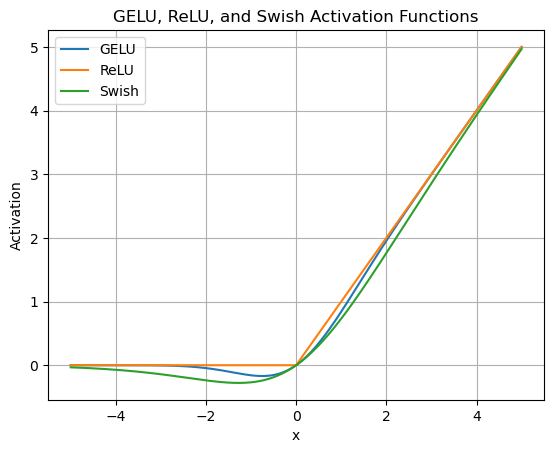

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def gelu(x):
   return x * norm.cdf(x)

def relu(x):
   return np.maximum(0, x)

def swish(x, beta=1):
   return x * (1 / (1 + np.exp(-beta * x)))

x_values = np.linspace(-5, 5, 500)
gelu_values = gelu(x_values)
relu_values = relu(x_values)
swish_values = swish(x_values)

plt.plot(x_values, gelu_values, label='GELU')
plt.plot(x_values, relu_values, label='ReLU')
plt.plot(x_values, swish_values, label='Swish')
plt.title("GELU, ReLU, and Swish Activation Functions")
plt.xlabel("x")
plt.ylabel("Activation")
plt.grid()
plt.legend()
plt.show()

In particular models, the dimensionality of certain layers is adjusted when employing the SwiGLU activation function. The cited adjustment is from $ 4d $ to $ \frac{2}{3} 4d $, as opposed to the dimensionality used in a model referred to as PaLM【19†source】【20†source】【21†source】【22†source】. This adjustment is in an effort to maintain a constant number of parameters and computational load, despite the use of different activation functions or variants of the Transformer's feed-forward networks (FFN) layers【15†source】.

Specifically, in the context of Transformer models, the adjustment in dimensionality accompanies the replacement of ReLU with the SwiGLU activation function in the feed-forward sublayers. This replacement and dimensionality adjustment is part of efforts to explore variants of the Gated Linear Units (GLU) in Transformer models to potentially enhance performance.

The SwiGLU activation function and the dimensionality adjustment are part of a broader discussion on enhancing the performance of Transformer models through the exploration of different activation functions and their impact on the model architecture and computational efficiency.

In [32]:
class FeedForward(nn.Module):
    
    def __init__(self, config: LlamaConfig) -> None:
        super().__init__()
        
    
        hidden_dim = 4 * config.hidden_size
        hidden_dim = int(2 * hidden_dim / 3)
        # custom dim factor multiplier
        if config.ffn_dim_multiplier is not None:
            hidden_dim = int(config.ffn_dim_multiplier * hidden_dim)
        hidden_dim = config.multiple_of * ((hidden_dim + config.multiple_of - 1) // config.multiple_of)
        
        self.w1 = nn.Linear(config.hidden_size, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, config.hidden_size, bias=False)
        self.w3 = nn.Linear(config.hidden_size, hidden_dim, bias=False)

        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2(F.silu(self.w1(x)) * self.w3(x))  

In [33]:
class LlamaBlock(nn.Module):
    """"""
    def __init__(self, config: LlamaConfig) -> None:
        super().__init__()
        
        self.hidden_size = config.hidden_size
        self.n_heads = config.n_query_heads
        self.head_dim = self.hidden_size // self.n_heads # 4096 // 32 = 128
        
        self.attention = SelfAttention (config)
        self.ffn = FeedForward(config)
        self.attention_norm = RMSNorm(config)
        self.ffn_norm = RMSNorm(config)
        
    def forward(self, x: torch.Tensor, position: int, freq_complex: torch.Tensor) -> torch.Tensor:
        # x: (B, seq_len, hidden_size)
        x = x + self.attention(self.attention_norm(x), position, freq_complex) # (B, seq_len, hidden_size)
        x = x + self.ffn(self.ffn_norm(x))
        return x

In [34]:
class LLaMA(nn.Module):
    
    def __init__(self, config: LlamaConfig) -> None:
        super().__init__()
        
        assert config.vocab_size != -1, 'vocab_size must be specified'

        self.device = config.device
        
        self.embeddings = nn.Embedding(config.vocab_size, config.hidden_size) 
        self.freq_complex = self._precompute_pos_frequencies(config=config)
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config.n_layers)])
        )
        self.rms_norm = RMSNorm(config)
        self.head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

    def _precompute_pos_frequencies(self, config: LlamaConfig) -> torch.Tensor:
        """Precompute positional frequencies for sinusoidal positional embeddings."""
        
        theta = 10000.0
        hidden_size = config.hidden_size
        max_seq_len = config.max_seq_len * 2
        device = config.device
        
        assert hidden_size % 2 == 0, 'hidden_size must be even: RoPe cannot be appied to odd-dimensional embeddings'
        
        # theta_i = 1000 ^ (-2(i) / hidden_size) for i in [1, 2, ..., hidden_size/2]
        thetas = (1 / theta) ** (torch.arange(0, hidden_size, 2) / hidden_size) #[hidden_size//2, ]
        m = torch.arange(max_seq_len, dtype=torch.float) # (max_seq_len, )
        freqs = torch.outer(m, thetas) # (max_seq_len, hidden_size/2)
        freqs_complex = torch.polar(torch.ones_like(freqs), freqs).to(device) # (max_seq_len, hidden_size/2)
        return freqs_complex    
    
        
    def forward(self, input_ids: torch.Tensor, start_position: int, target: torch.Tensor = None) -> torch.Tensor:
        # input_ids: (batch_size, seq_len)
        bs, seq_len = input_ids.shape
        assert seq_len == 1, 'sequence length must be 1'
        
        token_embeddings = self.embeddings(input_ids) # (batch_size, seq_len, hidden_size): (bs, 1, 4096)
        freq_complex = self.freq_complex[start_position:start_position + seq_len] # (batch_size, hidden_size)
        
        for layer in self.llama_blocks:
            token_embeddings = layer(token_embeddings, start_position, freq_complex)
        logits = self.head(self.rms_norm(token_embeddings))
        
        if target is None:
            return {'logits': logits}
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target.view(-1))
            return {'logits': logits, 'loss': loss}

In [35]:
model = LLaMA(LlamaConfig(vocab_size=32000, device='cpu'))

In [36]:
import json
import time
from tokenizers import Tokenizer
from pathlib import Path
from sentencepiece import SentencePieceProcessor

In [37]:
class LLaMAModel(nn.Module):
    
    def __init__(self, model: LLaMA) -> None:
        super().__init__()
        
    @staticmethod
    def build(
        ckpt_dir: str,
        tokenizer_path: str,
        config_path: str,
        max_seq_len: int,
        max_batch_size: int,
        seed: int = 42,
        device: str = None
        ) -> 'LLaMAModel':
        
        if device is None:
            device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f'>>> Using device: {device}')
        
        start = time.time()
        model_path = list(Path(ckpt_dir).glob('*.pth'))
        assert len(model_path) > 0, 'No model checkpoint provided!'
        ckpt_path = model_path[0]
        print(f'>>> Loading checkpoint from {ckpt_path}')
        checkpoint = torch.load(ckpt_path, map_location='cpu')
        print(f'>>> Checkpoint loaded in {time.time() - start:.2f} seconds') 
        
        with open(config_path, 'rb') as f:
            config = json.load(f)
        
        config: LlamaConfig = LlamaConfig(
            max_batch_size=max_batch_size,
            max_seq_len=max_seq_len,
            device=device,
            **config
        )
        print(f'>>> Using config: {config}')
        
        start = time.time()
        tokenizer = SentencePieceProcessor()
        tokenizer.load(tokenizer_path)
        config.vocab_size = tokenizer.vocab_size()
        print(f'>>> Tokenizer loaded in {time.time() - start:.2f} seconds')
        
        if device == 'cuda':
            torch.set_default_tensor_type(torch.cuda.HalfTensor)
        elif device == 'mps':
            torch.set_default_tensor_type(torch.FloatTensor)
        else:
            torch.set_default_tensor_type(torch.BFloat16Tensor)
            
        torch.manual_seed(seed)
        
        start = time.time()
        model = LLaMA(config)
        del checkpoint['rope.freqs']
        model.load_state_dict(checkpoint['model_state_dict'], strict=True)
        print(f'>>> Model loaded in {time.time() - start:.2f} seconds')
        
        return {'model': model, 'tokenizer': tokenizer, 'config': config}

In [38]:
# print(list((Path('../llama-2-7b/').glob('*.pth'))))
# llama_dict = LLaMAModel.build(
#     ckpt_dir='../llama-2-7b/',
#     tokenizer_path='../tokenizer.model',
#     config_path='../llama-2-7b/config.json',
#     max_seq_len=1024,
#     max_batch_size=3,
# )
# print('All ok!')

In [39]:
checkpoint = torch.load('../llama-2-7b/consolidated.00.pth', map_location='cpu')

In [40]:
# for k in checkpoint.keys(): print(k)
# for name, param in model.state_dict().items():
#     print(name)

In [41]:
converted = {}

In [42]:
converted['embeddings.weight'] = checkpoint['tok_embeddings.weight']
converted['rms_norm.scale'] = checkpoint['norm.weight']
converted['head.weight'] = checkpoint['output.weight']
converted['llama_blocks.llama_0.attention.wq.weight'] = checkpoint['layers.0.attention.wq.weight']
converted['llama_blocks.llama_0.attention.wk.weight'] = checkpoint['layers.0.attention.wk.weight']
converted['llama_blocks.llama_0.attention.wv.weight'] = checkpoint['layers.0.attention.wv.weight']
converted['llama_blocks.llama_0.attention.wo.weight'] = checkpoint['layers.0.attention.wo.weight']
converted['llama_blocks.llama_0.ffn.w1.weight'] = checkpoint['layers.0.feed_forward.w1.weight']
converted['llama_blocks.llama_0.ffn.w2.weight'] = checkpoint['layers.0.feed_forward.w2.weight']
converted['llama_blocks.llama_0.ffn.w3.weight'] = checkpoint['layers.0.feed_forward.w3.weight']
converted['llama_blocks.llama_0.attention_norm.scale'] = checkpoint['layers.0.attention_norm.weight']
converted['llama_blocks.llama_0.ffn_norm.scale'] = checkpoint['layers.0.ffn_norm.weight']
converted['llama_blocks.llama_1.attention.wq.weight'] = checkpoint['layers.1.attention.wq.weight']
converted['llama_blocks.llama_1.attention.wk.weight'] = checkpoint['layers.1.attention.wk.weight']
converted['llama_blocks.llama_1.attention.wv.weight'] = checkpoint['layers.1.attention.wv.weight']
converted['llama_blocks.llama_1.attention.wo.weight'] = checkpoint['layers.1.attention.wo.weight']
converted['llama_blocks.llama_1.ffn.w1.weight'] = checkpoint['layers.1.feed_forward.w1.weight']
converted['llama_blocks.llama_1.ffn.w2.weight'] = checkpoint['layers.1.feed_forward.w2.weight']
converted['llama_blocks.llama_1.ffn.w3.weight'] = checkpoint['layers.1.feed_forward.w3.weight']
converted['llama_blocks.llama_1.attention_norm.scale'] = checkpoint['layers.1.attention_norm.weight']
converted['llama_blocks.llama_1.ffn_norm.scale'] = checkpoint['layers.1.ffn_norm.weight']
converted['llama_blocks.llama_2.attention.wq.weight'] = checkpoint['layers.2.attention.wq.weight']
converted['llama_blocks.llama_2.attention.wk.weight'] = checkpoint['layers.2.attention.wk.weight']
converted['llama_blocks.llama_2.attention.wv.weight'] = checkpoint['layers.2.attention.wv.weight']
converted['llama_blocks.llama_2.attention.wo.weight'] = checkpoint['layers.2.attention.wo.weight']
converted['llama_blocks.llama_2.ffn.w1.weight'] = checkpoint['layers.2.feed_forward.w1.weight']
converted['llama_blocks.llama_2.ffn.w2.weight'] = checkpoint['layers.2.feed_forward.w2.weight']
converted['llama_blocks.llama_2.ffn.w3.weight'] = checkpoint['layers.2.feed_forward.w3.weight']
converted['llama_blocks.llama_2.attention_norm.scale'] = checkpoint['layers.2.attention_norm.weight']
converted['llama_blocks.llama_2.ffn_norm.scale'] = checkpoint['layers.2.ffn_norm.weight']
converted['llama_blocks.llama_3.attention.wq.weight'] = checkpoint['layers.3.attention.wq.weight']
converted['llama_blocks.llama_3.attention.wk.weight'] = checkpoint['layers.3.attention.wk.weight']
converted['llama_blocks.llama_3.attention.wv.weight'] = checkpoint['layers.3.attention.wv.weight']
converted['llama_blocks.llama_3.attention.wo.weight'] = checkpoint['layers.3.attention.wo.weight']
converted['llama_blocks.llama_3.ffn.w1.weight'] = checkpoint['layers.3.feed_forward.w1.weight']
converted['llama_blocks.llama_3.ffn.w2.weight'] = checkpoint['layers.3.feed_forward.w2.weight']
converted['llama_blocks.llama_3.ffn.w3.weight'] = checkpoint['layers.3.feed_forward.w3.weight']
converted['llama_blocks.llama_3.attention_norm.scale'] = checkpoint['layers.3.attention_norm.weight']
converted['llama_blocks.llama_3.ffn_norm.scale'] = checkpoint['layers.3.ffn_norm.weight']
converted['llama_blocks.llama_4.attention.wq.weight'] = checkpoint['layers.4.attention.wq.weight']
converted['llama_blocks.llama_4.attention.wk.weight'] = checkpoint['layers.4.attention.wk.weight']
converted['llama_blocks.llama_4.attention.wv.weight'] = checkpoint['layers.4.attention.wv.weight']
converted['llama_blocks.llama_4.attention.wo.weight'] = checkpoint['layers.4.attention.wo.weight']
converted['llama_blocks.llama_4.ffn.w1.weight'] = checkpoint['layers.4.feed_forward.w1.weight']
converted['llama_blocks.llama_4.ffn.w2.weight'] = checkpoint['layers.4.feed_forward.w2.weight']
converted['llama_blocks.llama_4.ffn.w3.weight'] = checkpoint['layers.4.feed_forward.w3.weight']
converted['llama_blocks.llama_4.attention_norm.scale'] = checkpoint['layers.4.attention_norm.weight']
converted['llama_blocks.llama_4.ffn_norm.scale'] = checkpoint['layers.4.ffn_norm.weight']
converted['llama_blocks.llama_5.attention.wq.weight'] = checkpoint['layers.5.attention.wq.weight']
converted['llama_blocks.llama_5.attention.wk.weight'] = checkpoint['layers.5.attention.wk.weight']
converted['llama_blocks.llama_5.attention.wv.weight'] = checkpoint['layers.5.attention.wv.weight']
converted['llama_blocks.llama_5.attention.wo.weight'] = checkpoint['layers.5.attention.wo.weight']
converted['llama_blocks.llama_5.ffn.w1.weight'] = checkpoint['layers.5.feed_forward.w1.weight']
converted['llama_blocks.llama_5.ffn.w2.weight'] = checkpoint['layers.5.feed_forward.w2.weight']
converted['llama_blocks.llama_5.ffn.w3.weight'] = checkpoint['layers.5.feed_forward.w3.weight']
converted['llama_blocks.llama_5.attention_norm.scale'] = checkpoint['layers.5.attention_norm.weight']
converted['llama_blocks.llama_5.ffn_norm.scale'] = checkpoint['layers.5.ffn_norm.weight']
converted['llama_blocks.llama_6.attention.wq.weight'] = checkpoint['layers.6.attention.wq.weight']
converted['llama_blocks.llama_6.attention.wk.weight'] = checkpoint['layers.6.attention.wk.weight']
converted['llama_blocks.llama_6.attention.wv.weight'] = checkpoint['layers.6.attention.wv.weight']
converted['llama_blocks.llama_6.attention.wo.weight'] = checkpoint['layers.6.attention.wo.weight']
converted['llama_blocks.llama_6.ffn.w1.weight'] = checkpoint['layers.6.feed_forward.w1.weight']
converted['llama_blocks.llama_6.ffn.w2.weight'] = checkpoint['layers.6.feed_forward.w2.weight']
converted['llama_blocks.llama_6.ffn.w3.weight'] = checkpoint['layers.6.feed_forward.w3.weight']
converted['llama_blocks.llama_6.attention_norm.scale'] = checkpoint['layers.6.attention_norm.weight']
converted['llama_blocks.llama_6.ffn_norm.scale'] = checkpoint['layers.6.ffn_norm.weight']
converted['llama_blocks.llama_7.attention.wq.weight'] = checkpoint['layers.7.attention.wq.weight']
converted['llama_blocks.llama_7.attention.wk.weight'] = checkpoint['layers.7.attention.wk.weight']
converted['llama_blocks.llama_7.attention.wv.weight'] = checkpoint['layers.7.attention.wv.weight']
converted['llama_blocks.llama_7.attention.wo.weight'] = checkpoint['layers.7.attention.wo.weight']
converted['llama_blocks.llama_7.ffn.w1.weight'] = checkpoint['layers.7.feed_forward.w1.weight']
converted['llama_blocks.llama_7.ffn.w2.weight'] = checkpoint['layers.7.feed_forward.w2.weight']
converted['llama_blocks.llama_7.ffn.w3.weight'] = checkpoint['layers.7.feed_forward.w3.weight']
converted['llama_blocks.llama_7.attention_norm.scale'] = checkpoint['layers.7.attention_norm.weight']
converted['llama_blocks.llama_7.ffn_norm.scale'] = checkpoint['layers.7.ffn_norm.weight']
converted['llama_blocks.llama_8.attention.wq.weight'] = checkpoint['layers.8.attention.wq.weight']
converted['llama_blocks.llama_8.attention.wk.weight'] = checkpoint['layers.8.attention.wk.weight']
converted['llama_blocks.llama_8.attention.wv.weight'] = checkpoint['layers.8.attention.wv.weight']
converted['llama_blocks.llama_8.attention.wo.weight'] = checkpoint['layers.8.attention.wo.weight']
converted['llama_blocks.llama_8.ffn.w1.weight'] = checkpoint['layers.8.feed_forward.w1.weight']
converted['llama_blocks.llama_8.ffn.w2.weight'] = checkpoint['layers.8.feed_forward.w2.weight']
converted['llama_blocks.llama_8.ffn.w3.weight'] = checkpoint['layers.8.feed_forward.w3.weight']
converted['llama_blocks.llama_8.attention_norm.scale'] = checkpoint['layers.8.attention_norm.weight']
converted['llama_blocks.llama_8.ffn_norm.scale'] = checkpoint['layers.8.ffn_norm.weight']
converted['llama_blocks.llama_9.attention.wq.weight'] = checkpoint['layers.9.attention.wq.weight']
converted['llama_blocks.llama_9.attention.wk.weight'] = checkpoint['layers.9.attention.wk.weight']
converted['llama_blocks.llama_9.attention.wv.weight'] = checkpoint['layers.9.attention.wv.weight']
converted['llama_blocks.llama_9.attention.wo.weight'] = checkpoint['layers.9.attention.wo.weight']
converted['llama_blocks.llama_9.ffn.w1.weight'] = checkpoint['layers.9.feed_forward.w1.weight']
converted['llama_blocks.llama_9.ffn.w2.weight'] = checkpoint['layers.9.feed_forward.w2.weight']
converted['llama_blocks.llama_9.ffn.w3.weight'] = checkpoint['layers.9.feed_forward.w3.weight']
converted['llama_blocks.llama_9.attention_norm.scale'] = checkpoint['layers.9.attention_norm.weight']
converted['llama_blocks.llama_9.ffn_norm.scale'] = checkpoint['layers.9.ffn_norm.weight']
converted['llama_blocks.llama_10.attention.wq.weight'] = checkpoint['layers.10.attention.wq.weight']
converted['llama_blocks.llama_10.attention.wk.weight'] = checkpoint['layers.10.attention.wk.weight']
converted['llama_blocks.llama_10.attention.wv.weight'] = checkpoint['layers.10.attention.wv.weight']
converted['llama_blocks.llama_10.attention.wo.weight'] = checkpoint['layers.10.attention.wo.weight']
converted['llama_blocks.llama_10.ffn.w1.weight'] = checkpoint['layers.10.feed_forward.w1.weight']
converted['llama_blocks.llama_10.ffn.w2.weight'] = checkpoint['layers.10.feed_forward.w2.weight']
converted['llama_blocks.llama_10.ffn.w3.weight'] = checkpoint['layers.10.feed_forward.w3.weight']
converted['llama_blocks.llama_10.attention_norm.scale'] = checkpoint['layers.10.attention_norm.weight']
converted['llama_blocks.llama_10.ffn_norm.scale'] = checkpoint['layers.10.ffn_norm.weight']
converted['llama_blocks.llama_11.attention.wq.weight'] = checkpoint['layers.11.attention.wq.weight']
converted['llama_blocks.llama_11.attention.wk.weight'] = checkpoint['layers.11.attention.wk.weight']
converted['llama_blocks.llama_11.attention.wv.weight'] = checkpoint['layers.11.attention.wv.weight']
converted['llama_blocks.llama_11.attention.wo.weight'] = checkpoint['layers.11.attention.wo.weight']
converted['llama_blocks.llama_11.ffn.w1.weight'] = checkpoint['layers.11.feed_forward.w1.weight']
converted['llama_blocks.llama_11.ffn.w2.weight'] = checkpoint['layers.11.feed_forward.w2.weight']
converted['llama_blocks.llama_11.ffn.w3.weight'] = checkpoint['layers.11.feed_forward.w3.weight']
converted['llama_blocks.llama_11.attention_norm.scale'] = checkpoint['layers.11.attention_norm.weight']
converted['llama_blocks.llama_11.ffn_norm.scale'] = checkpoint['layers.11.ffn_norm.weight']
converted['llama_blocks.llama_12.attention.wq.weight'] = checkpoint['layers.12.attention.wq.weight']
converted['llama_blocks.llama_12.attention.wk.weight'] = checkpoint['layers.12.attention.wk.weight']
converted['llama_blocks.llama_12.attention.wv.weight'] = checkpoint['layers.12.attention.wv.weight']
converted['llama_blocks.llama_12.attention.wo.weight'] = checkpoint['layers.12.attention.wo.weight']
converted['llama_blocks.llama_12.ffn.w1.weight'] = checkpoint['layers.12.feed_forward.w1.weight']
converted['llama_blocks.llama_12.ffn.w2.weight'] = checkpoint['layers.12.feed_forward.w2.weight']
converted['llama_blocks.llama_12.ffn.w3.weight'] = checkpoint['layers.12.feed_forward.w3.weight']
converted['llama_blocks.llama_12.attention_norm.scale'] = checkpoint['layers.12.attention_norm.weight']
converted['llama_blocks.llama_12.ffn_norm.scale'] = checkpoint['layers.12.ffn_norm.weight']
converted['llama_blocks.llama_13.attention.wq.weight'] = checkpoint['layers.13.attention.wq.weight']
converted['llama_blocks.llama_13.attention.wk.weight'] = checkpoint['layers.13.attention.wk.weight']
converted['llama_blocks.llama_13.attention.wv.weight'] = checkpoint['layers.13.attention.wv.weight']
converted['llama_blocks.llama_13.attention.wo.weight'] = checkpoint['layers.13.attention.wo.weight']
converted['llama_blocks.llama_13.ffn.w1.weight'] = checkpoint['layers.13.feed_forward.w1.weight']
converted['llama_blocks.llama_13.ffn.w2.weight'] = checkpoint['layers.13.feed_forward.w2.weight']
converted['llama_blocks.llama_13.ffn.w3.weight'] = checkpoint['layers.13.feed_forward.w3.weight']
converted['llama_blocks.llama_13.attention_norm.scale'] = checkpoint['layers.13.attention_norm.weight']
converted['llama_blocks.llama_13.ffn_norm.scale'] = checkpoint['layers.13.ffn_norm.weight']
converted['llama_blocks.llama_14.attention.wq.weight'] = checkpoint['layers.14.attention.wq.weight']
converted['llama_blocks.llama_14.attention.wk.weight'] = checkpoint['layers.14.attention.wk.weight']
converted['llama_blocks.llama_14.attention.wv.weight'] = checkpoint['layers.14.attention.wv.weight']
converted['llama_blocks.llama_14.attention.wo.weight'] = checkpoint['layers.14.attention.wo.weight']
converted['llama_blocks.llama_14.ffn.w1.weight'] = checkpoint['layers.14.feed_forward.w1.weight']
converted['llama_blocks.llama_14.ffn.w2.weight'] = checkpoint['layers.14.feed_forward.w2.weight']
converted['llama_blocks.llama_14.ffn.w3.weight'] = checkpoint['layers.14.feed_forward.w3.weight']
converted['llama_blocks.llama_14.attention_norm.scale'] = checkpoint['layers.14.attention_norm.weight']
converted['llama_blocks.llama_14.ffn_norm.scale'] = checkpoint['layers.14.ffn_norm.weight']
converted['llama_blocks.llama_15.attention.wq.weight'] = checkpoint['layers.15.attention.wq.weight']
converted['llama_blocks.llama_15.attention.wk.weight'] = checkpoint['layers.15.attention.wk.weight']
converted['llama_blocks.llama_15.attention.wv.weight'] = checkpoint['layers.15.attention.wv.weight']
converted['llama_blocks.llama_15.attention.wo.weight'] = checkpoint['layers.15.attention.wo.weight']
converted['llama_blocks.llama_15.ffn.w1.weight'] = checkpoint['layers.15.feed_forward.w1.weight']
converted['llama_blocks.llama_15.ffn.w2.weight'] = checkpoint['layers.15.feed_forward.w2.weight']
converted['llama_blocks.llama_15.ffn.w3.weight'] = checkpoint['layers.15.feed_forward.w3.weight']
converted['llama_blocks.llama_15.attention_norm.scale'] = checkpoint['layers.15.attention_norm.weight']
converted['llama_blocks.llama_15.ffn_norm.scale'] = checkpoint['layers.15.ffn_norm.weight']
converted['llama_blocks.llama_16.attention.wq.weight'] = checkpoint['layers.16.attention.wq.weight']
converted['llama_blocks.llama_16.attention.wk.weight'] = checkpoint['layers.16.attention.wk.weight']
converted['llama_blocks.llama_16.attention.wv.weight'] = checkpoint['layers.16.attention.wv.weight']
converted['llama_blocks.llama_16.attention.wo.weight'] = checkpoint['layers.16.attention.wo.weight']
converted['llama_blocks.llama_16.ffn.w1.weight'] = checkpoint['layers.16.feed_forward.w1.weight']
converted['llama_blocks.llama_16.ffn.w2.weight'] = checkpoint['layers.16.feed_forward.w2.weight']
converted['llama_blocks.llama_16.ffn.w3.weight'] = checkpoint['layers.16.feed_forward.w3.weight']
converted['llama_blocks.llama_16.attention_norm.scale'] = checkpoint['layers.16.attention_norm.weight']
converted['llama_blocks.llama_16.ffn_norm.scale'] = checkpoint['layers.16.ffn_norm.weight']
converted['llama_blocks.llama_17.attention.wq.weight'] = checkpoint['layers.17.attention.wq.weight']
converted['llama_blocks.llama_17.attention.wk.weight'] = checkpoint['layers.17.attention.wk.weight']
converted['llama_blocks.llama_17.attention.wv.weight'] = checkpoint['layers.17.attention.wv.weight']
converted['llama_blocks.llama_17.attention.wo.weight'] = checkpoint['layers.17.attention.wo.weight']
converted['llama_blocks.llama_17.ffn.w1.weight'] = checkpoint['layers.17.feed_forward.w1.weight']
converted['llama_blocks.llama_17.ffn.w2.weight'] = checkpoint['layers.17.feed_forward.w2.weight']
converted['llama_blocks.llama_17.ffn.w3.weight'] = checkpoint['layers.17.feed_forward.w3.weight']
converted['llama_blocks.llama_17.attention_norm.scale'] = checkpoint['layers.17.attention_norm.weight']
converted['llama_blocks.llama_17.ffn_norm.scale'] = checkpoint['layers.17.ffn_norm.weight']
converted['llama_blocks.llama_18.attention.wq.weight'] = checkpoint['layers.18.attention.wq.weight']
converted['llama_blocks.llama_18.attention.wk.weight'] = checkpoint['layers.18.attention.wk.weight']
converted['llama_blocks.llama_18.attention.wv.weight'] = checkpoint['layers.18.attention.wv.weight']
converted['llama_blocks.llama_18.attention.wo.weight'] = checkpoint['layers.18.attention.wo.weight']
converted['llama_blocks.llama_18.ffn.w1.weight'] = checkpoint['layers.18.feed_forward.w1.weight']
converted['llama_blocks.llama_18.ffn.w2.weight'] = checkpoint['layers.18.feed_forward.w2.weight']
converted['llama_blocks.llama_18.ffn.w3.weight'] = checkpoint['layers.18.feed_forward.w3.weight']
converted['llama_blocks.llama_18.attention_norm.scale'] = checkpoint['layers.18.attention_norm.weight']
converted['llama_blocks.llama_18.ffn_norm.scale'] = checkpoint['layers.18.ffn_norm.weight']
converted['llama_blocks.llama_19.attention.wq.weight'] = checkpoint['layers.19.attention.wq.weight']
converted['llama_blocks.llama_19.attention.wk.weight'] = checkpoint['layers.19.attention.wk.weight']
converted['llama_blocks.llama_19.attention.wv.weight'] = checkpoint['layers.19.attention.wv.weight']
converted['llama_blocks.llama_19.attention.wo.weight'] = checkpoint['layers.19.attention.wo.weight']
converted['llama_blocks.llama_19.ffn.w1.weight'] = checkpoint['layers.19.feed_forward.w1.weight']
converted['llama_blocks.llama_19.ffn.w2.weight'] = checkpoint['layers.19.feed_forward.w2.weight']
converted['llama_blocks.llama_19.ffn.w3.weight'] = checkpoint['layers.19.feed_forward.w3.weight']
converted['llama_blocks.llama_19.attention_norm.scale'] = checkpoint['layers.19.attention_norm.weight']
converted['llama_blocks.llama_19.ffn_norm.scale'] = checkpoint['layers.19.ffn_norm.weight']
converted['llama_blocks.llama_20.attention.wq.weight'] = checkpoint['layers.20.attention.wq.weight']
converted['llama_blocks.llama_20.attention.wk.weight'] = checkpoint['layers.20.attention.wk.weight']
converted['llama_blocks.llama_20.attention.wv.weight'] = checkpoint['layers.20.attention.wv.weight']
converted['llama_blocks.llama_20.attention.wo.weight'] = checkpoint['layers.20.attention.wo.weight']
converted['llama_blocks.llama_20.ffn.w1.weight'] = checkpoint['layers.20.feed_forward.w1.weight']
converted['llama_blocks.llama_20.ffn.w2.weight'] = checkpoint['layers.20.feed_forward.w2.weight']
converted['llama_blocks.llama_20.ffn.w3.weight'] = checkpoint['layers.20.feed_forward.w3.weight']
converted['llama_blocks.llama_20.attention_norm.scale'] = checkpoint['layers.20.attention_norm.weight']
converted['llama_blocks.llama_20.ffn_norm.scale'] = checkpoint['layers.20.ffn_norm.weight']
converted['llama_blocks.llama_21.attention.wq.weight'] = checkpoint['layers.21.attention.wq.weight']
converted['llama_blocks.llama_21.attention.wk.weight'] = checkpoint['layers.21.attention.wk.weight']
converted['llama_blocks.llama_21.attention.wv.weight'] = checkpoint['layers.21.attention.wv.weight']
converted['llama_blocks.llama_21.attention.wo.weight'] = checkpoint['layers.21.attention.wo.weight']
converted['llama_blocks.llama_21.ffn.w1.weight'] = checkpoint['layers.21.feed_forward.w1.weight']
converted['llama_blocks.llama_21.ffn.w2.weight'] = checkpoint['layers.21.feed_forward.w2.weight']
converted['llama_blocks.llama_21.ffn.w3.weight'] = checkpoint['layers.21.feed_forward.w3.weight']
converted['llama_blocks.llama_21.attention_norm.scale'] = checkpoint['layers.21.attention_norm.weight']
converted['llama_blocks.llama_21.ffn_norm.scale'] = checkpoint['layers.21.ffn_norm.weight']
converted['llama_blocks.llama_22.attention.wq.weight'] = checkpoint['layers.22.attention.wq.weight']
converted['llama_blocks.llama_22.attention.wk.weight'] = checkpoint['layers.22.attention.wk.weight']
converted['llama_blocks.llama_22.attention.wv.weight'] = checkpoint['layers.22.attention.wv.weight']
converted['llama_blocks.llama_22.attention.wo.weight'] = checkpoint['layers.22.attention.wo.weight']
converted['llama_blocks.llama_22.ffn.w1.weight'] = checkpoint['layers.22.feed_forward.w1.weight']
converted['llama_blocks.llama_22.ffn.w2.weight'] = checkpoint['layers.22.feed_forward.w2.weight']
converted['llama_blocks.llama_22.ffn.w3.weight'] = checkpoint['layers.22.feed_forward.w3.weight']
converted['llama_blocks.llama_22.attention_norm.scale'] = checkpoint['layers.22.attention_norm.weight']
converted['llama_blocks.llama_22.ffn_norm.scale'] = checkpoint['layers.22.ffn_norm.weight']
converted['llama_blocks.llama_23.attention.wq.weight'] = checkpoint['layers.23.attention.wq.weight']
converted['llama_blocks.llama_23.attention.wk.weight'] = checkpoint['layers.23.attention.wk.weight']
converted['llama_blocks.llama_23.attention.wv.weight'] = checkpoint['layers.23.attention.wv.weight']
converted['llama_blocks.llama_23.attention.wo.weight'] = checkpoint['layers.23.attention.wo.weight']
converted['llama_blocks.llama_23.ffn.w1.weight'] = checkpoint['layers.23.feed_forward.w1.weight']
converted['llama_blocks.llama_23.ffn.w2.weight'] = checkpoint['layers.23.feed_forward.w2.weight']
converted['llama_blocks.llama_23.ffn.w3.weight'] = checkpoint['layers.23.feed_forward.w3.weight']
converted['llama_blocks.llama_23.attention_norm.scale'] = checkpoint['layers.23.attention_norm.weight']
converted['llama_blocks.llama_23.ffn_norm.scale'] = checkpoint['layers.23.ffn_norm.weight']
converted['llama_blocks.llama_24.attention.wq.weight'] = checkpoint['layers.24.attention.wq.weight']
converted['llama_blocks.llama_24.attention.wk.weight'] = checkpoint['layers.24.attention.wk.weight']
converted['llama_blocks.llama_24.attention.wv.weight'] = checkpoint['layers.24.attention.wv.weight']
converted['llama_blocks.llama_24.attention.wo.weight'] = checkpoint['layers.24.attention.wo.weight']
converted['llama_blocks.llama_24.ffn.w1.weight'] = checkpoint['layers.24.feed_forward.w1.weight']
converted['llama_blocks.llama_24.ffn.w2.weight'] = checkpoint['layers.24.feed_forward.w2.weight']
converted['llama_blocks.llama_24.ffn.w3.weight'] = checkpoint['layers.24.feed_forward.w3.weight']
converted['llama_blocks.llama_24.attention_norm.scale'] = checkpoint['layers.24.attention_norm.weight']
converted['llama_blocks.llama_24.ffn_norm.scale'] = checkpoint['layers.24.ffn_norm.weight']
converted['llama_blocks.llama_25.attention.wq.weight'] = checkpoint['layers.25.attention.wq.weight']
converted['llama_blocks.llama_25.attention.wk.weight'] = checkpoint['layers.25.attention.wk.weight']
converted['llama_blocks.llama_25.attention.wv.weight'] = checkpoint['layers.25.attention.wv.weight']
converted['llama_blocks.llama_25.attention.wo.weight'] = checkpoint['layers.25.attention.wo.weight']
converted['llama_blocks.llama_25.ffn.w1.weight'] = checkpoint['layers.25.feed_forward.w1.weight']
converted['llama_blocks.llama_25.ffn.w2.weight'] = checkpoint['layers.25.feed_forward.w2.weight']
converted['llama_blocks.llama_25.ffn.w3.weight'] = checkpoint['layers.25.feed_forward.w3.weight']
converted['llama_blocks.llama_25.attention_norm.scale'] = checkpoint['layers.25.attention_norm.weight']
converted['llama_blocks.llama_25.ffn_norm.scale'] = checkpoint['layers.25.ffn_norm.weight']
converted['llama_blocks.llama_26.attention.wq.weight'] = checkpoint['layers.26.attention.wq.weight']
converted['llama_blocks.llama_26.attention.wk.weight'] = checkpoint['layers.26.attention.wk.weight']
converted['llama_blocks.llama_26.attention.wv.weight'] = checkpoint['layers.26.attention.wv.weight']
converted['llama_blocks.llama_26.attention.wo.weight'] = checkpoint['layers.26.attention.wo.weight']
converted['llama_blocks.llama_26.ffn.w1.weight'] = checkpoint['layers.26.feed_forward.w1.weight']
converted['llama_blocks.llama_26.ffn.w2.weight'] = checkpoint['layers.26.feed_forward.w2.weight']
converted['llama_blocks.llama_26.ffn.w3.weight'] = checkpoint['layers.26.feed_forward.w3.weight']
converted['llama_blocks.llama_26.attention_norm.scale'] = checkpoint['layers.26.attention_norm.weight']
converted['llama_blocks.llama_26.ffn_norm.scale'] = checkpoint['layers.26.ffn_norm.weight']
converted['llama_blocks.llama_27.attention.wq.weight'] = checkpoint['layers.27.attention.wq.weight']
converted['llama_blocks.llama_27.attention.wk.weight'] = checkpoint['layers.27.attention.wk.weight']
converted['llama_blocks.llama_27.attention.wv.weight'] = checkpoint['layers.27.attention.wv.weight']
converted['llama_blocks.llama_27.attention.wo.weight'] = checkpoint['layers.27.attention.wo.weight']
converted['llama_blocks.llama_27.ffn.w1.weight'] = checkpoint['layers.27.feed_forward.w1.weight']
converted['llama_blocks.llama_27.ffn.w2.weight'] = checkpoint['layers.27.feed_forward.w2.weight']
converted['llama_blocks.llama_27.ffn.w3.weight'] = checkpoint['layers.27.feed_forward.w3.weight']
converted['llama_blocks.llama_27.attention_norm.scale'] = checkpoint['layers.27.attention_norm.weight']
converted['llama_blocks.llama_27.ffn_norm.scale'] = checkpoint['layers.27.ffn_norm.weight']
converted['llama_blocks.llama_28.attention.wq.weight'] = checkpoint['layers.28.attention.wq.weight']
converted['llama_blocks.llama_28.attention.wk.weight'] = checkpoint['layers.28.attention.wk.weight']
converted['llama_blocks.llama_28.attention.wv.weight'] = checkpoint['layers.28.attention.wv.weight']
converted['llama_blocks.llama_28.attention.wo.weight'] = checkpoint['layers.28.attention.wo.weight']
converted['llama_blocks.llama_28.ffn.w1.weight'] = checkpoint['layers.28.feed_forward.w1.weight']
converted['llama_blocks.llama_28.ffn.w2.weight'] = checkpoint['layers.28.feed_forward.w2.weight']
converted['llama_blocks.llama_28.ffn.w3.weight'] = checkpoint['layers.28.feed_forward.w3.weight']
converted['llama_blocks.llama_28.attention_norm.scale'] = checkpoint['layers.28.attention_norm.weight']
converted['llama_blocks.llama_28.ffn_norm.scale'] = checkpoint['layers.28.ffn_norm.weight']
converted['llama_blocks.llama_29.attention.wq.weight'] = checkpoint['layers.29.attention.wq.weight']
converted['llama_blocks.llama_29.attention.wk.weight'] = checkpoint['layers.29.attention.wk.weight']
converted['llama_blocks.llama_29.attention.wv.weight'] = checkpoint['layers.29.attention.wv.weight']
converted['llama_blocks.llama_29.attention.wo.weight'] = checkpoint['layers.29.attention.wo.weight']
converted['llama_blocks.llama_29.ffn.w1.weight'] = checkpoint['layers.29.feed_forward.w1.weight']
converted['llama_blocks.llama_29.ffn.w2.weight'] = checkpoint['layers.29.feed_forward.w2.weight']
converted['llama_blocks.llama_29.ffn.w3.weight'] = checkpoint['layers.29.feed_forward.w3.weight']
converted['llama_blocks.llama_29.attention_norm.scale'] = checkpoint['layers.29.attention_norm.weight']
converted['llama_blocks.llama_29.ffn_norm.scale'] = checkpoint['layers.29.ffn_norm.weight']
converted['llama_blocks.llama_30.attention.wq.weight'] = checkpoint['layers.30.attention.wq.weight']
converted['llama_blocks.llama_30.attention.wk.weight'] = checkpoint['layers.30.attention.wk.weight']
converted['llama_blocks.llama_30.attention.wv.weight'] = checkpoint['layers.30.attention.wv.weight']
converted['llama_blocks.llama_30.attention.wo.weight'] = checkpoint['layers.30.attention.wo.weight']
converted['llama_blocks.llama_30.ffn.w1.weight'] = checkpoint['layers.30.feed_forward.w1.weight']
converted['llama_blocks.llama_30.ffn.w2.weight'] = checkpoint['layers.30.feed_forward.w2.weight']
converted['llama_blocks.llama_30.ffn.w3.weight'] = checkpoint['layers.30.feed_forward.w3.weight']
converted['llama_blocks.llama_30.attention_norm.scale'] = checkpoint['layers.30.attention_norm.weight']
converted['llama_blocks.llama_30.ffn_norm.scale'] = checkpoint['layers.30.ffn_norm.weight']
converted['llama_blocks.llama_31.attention.wq.weight'] = checkpoint['layers.31.attention.wq.weight']
converted['llama_blocks.llama_31.attention.wk.weight'] = checkpoint['layers.31.attention.wk.weight']
converted['llama_blocks.llama_31.attention.wv.weight'] = checkpoint['layers.31.attention.wv.weight']
converted['llama_blocks.llama_31.attention.wo.weight'] = checkpoint['layers.31.attention.wo.weight']
converted['llama_blocks.llama_31.ffn.w1.weight'] = checkpoint['layers.31.feed_forward.w1.weight']
converted['llama_blocks.llama_31.ffn.w2.weight'] = checkpoint['layers.31.feed_forward.w2.weight']
converted['llama_blocks.llama_31.ffn.w3.weight'] = checkpoint['layers.31.feed_forward.w3.weight']
converted['llama_blocks.llama_31.attention_norm.scale'] = checkpoint['layers.31.attention_norm.weight']
converted['llama_blocks.llama_31.ffn_norm.scale'] = checkpoint['layers.31.ffn_norm.weight']

In [43]:
model.load_state_dict(converted)

<All keys matched successfully>

: 